# Canny edge detection from scratch 

In [10]:
from skimage.io import imread
from scipy.ndimage import convolve, shift, label
from matplotlib.pyplot import imshow
from ipywidgets import interactive
from IPython.display import display
import matplotlib as mpl
import numpy as np

mpl.rc('image', cmap='gray')  # tell matplotlib to use gray shades for grayscale images

Load a test image and convert it to grayscale with pixel values between 0.0 and 1.0.

(1080, 1440)

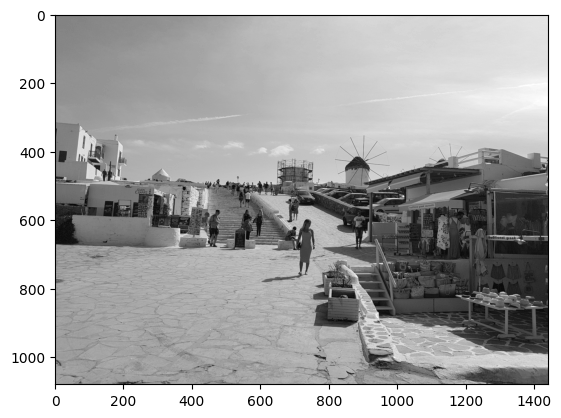

In [13]:
# img_name = 'imgs/stmoritz.jpg'
# img_name = 'imgs/stmoritz_fhd.jpg'
img_name = 'imgs/mykonos_fhd.jpg'


img = np.array(imread(img_name), dtype=float) 

# convert to grayscale 
img = np.linalg.norm(img, axis=2) /255

imshow(img)
img.shape

Apply Gaussian blur to remove unecessary small edges and sobel's edge detection.

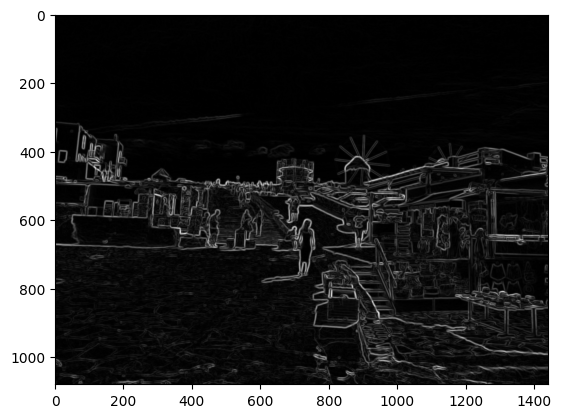

In [14]:
GAUSSIAN_SIZE = 9
GAUSSIAN_SIGMA = 2

def gaussian_filter(size, sigma):
    x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*sigma**2)))
    return g/g.sum()

sobel_x = np.array( [  [-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1] ])
sobel_y = sobel_x.transpose()

g = gaussian_filter(GAUSSIAN_SIZE, GAUSSIAN_SIGMA)

x_ker = convolve(g, sobel_x)
y_ker = convolve(g, sobel_y)

x_par = convolve(img, x_ker)
y_par = convolve(img, y_ker)

magnitude = (x_par*x_par + y_par*y_par) ** 0.5
direction = np.arctan2(y_par, x_par) + np.pi

imshow(magnitude)

Here the edges are partitioned into 4 categories according to their angle. There are horizontal (-), vertical (|), diag_right (/) and diag_left (\\) edges. 

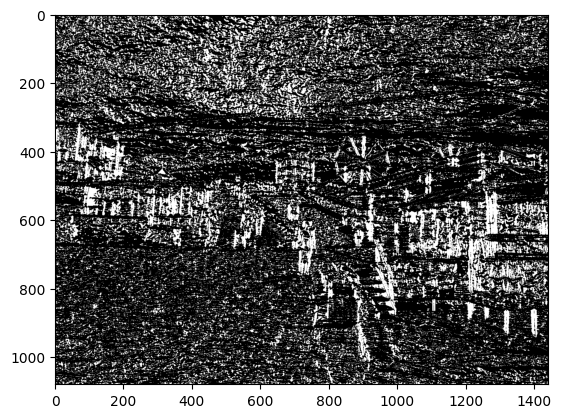

In [15]:
horizontal = np.zeros_like(direction) 
horizontal[(np.pi*2/3 >= direction[:,:]) * (direction[:,:] > np.pi/3)] = 1
horizontal[(np.pi*5/3 >= direction[:,:]) * (direction[:,:] > np.pi*4/3)] = 1

vertical = np.zeros_like(direction) 
vertical[(np.pi*1/6 >= direction[:,:]) ] = 1
vertical[(direction[:,:] >= np.pi*11/6)] = 1
vertical[(np.pi*7/6 >= direction[:,:]) * (direction[:,:] > np.pi*5/6)] = 1

diag_right = np.zeros_like(direction) 
diag_right[(np.pi*1/3 >= direction[:,:]) * (direction[:,:] > np.pi*1/6)] = 1
diag_right[(np.pi*4/3 >= direction[:,:]) * (direction[:,:] > np.pi*7/6)] = 1

diag_left = np.zeros_like(direction)
diag_left[(np.pi*5/6 >= direction[:,:]) * (direction[:,:] > np.pi*2/3)] = 1
diag_left[(np.pi*11/6 >= direction[:,:]) * (direction[:,:] > np.pi*5/3)] = 1

imshow(vertical)
# imshow(horizontal)
# imshow(diag_right)
# imshow(diag_left)

For each category of edge, non maximum suppression is applied. 

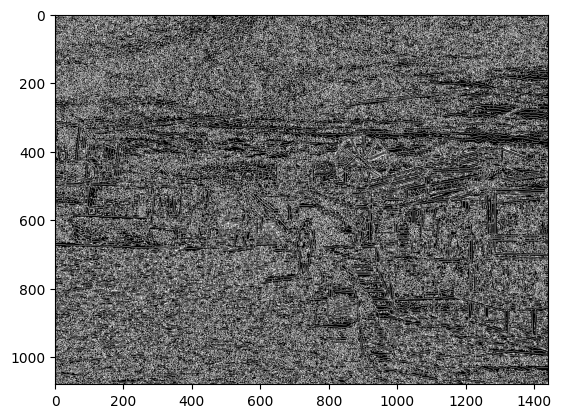

In [16]:

# vertical non maximum supression 
vert_mag = vertical * magnitude 

# move all pixels 1 pixel to the right 
vert_mag_right = np.roll(vert_mag, 1, axis=1)
vert_mag_right[:, 0] = 0

# move all pixels 1 pixel to the right 
vert_mag_left = np.roll(vert_mag, -1, axis=1)
vert_mag_left[:, -1] = 0

# compose mask
vert_max_mask = np.zeros_like(vert_mag)
vert_max_mask[(vert_mag_right < vert_mag) * (vert_mag_left < vert_mag)] = 1




# horizontal non maximum supression 
hor_mag = horizontal * magnitude

# move all pixels 1 to the top 
hor_mag_up = np.roll(hor_mag, -1, axis=0)
#hor_mag_up[:,-1] = 0

# move all pixels 1 to the bottom 
hor_mag_down = np.roll(hor_mag, 1, axis=0)
#hor_mag_down[0,:] = 0

# compose mask
hor_max_mask = np.zeros_like(hor_mag)
hor_max_mask[(hor_mag_up < hor_mag) * (hor_mag_down < hor_mag)] = 1




# diag right = / 
# perform diag right non maximum supression  
diag_right_mag = diag_right * magnitude 

# move all pixels 1 pixel to the right 
diag_right_mag_rd = np.roll(diag_right_mag, 1, axis=1)
diag_right_mag_rd[:, 0] = 0

# move all pixels 1 pixel down 
diag_right_mag_rd = np.roll(diag_right_mag_rd, 1, axis=0)
diag_right_mag_rd[0, :] = 0


# move all pixels 1 pixel to the right 
diag_right_mag_lu = np.roll(diag_right_mag, -1, axis=1)
diag_right_mag_lu[:, -1] = 0

# move all pixels 1 pixel down 
diag_right_mag_lu = np.roll(diag_right_mag_lu, -1, axis=0)
diag_right_mag_lu[-1, :] = 0

# compose mask 
diag_right_max_mask = np.zeros_like(hor_mag)
diag_right_max_mask[(diag_right_mag_lu < diag_right_mag) * (diag_right_mag_rd < diag_right_mag)] = 1



# diag left = \
# perform diag left non maximum supression  
diag_left_mag = diag_left * magnitude 

# move all pixels 1 pixel to the right 
diag_left_mag_ur = np.roll(diag_left_mag, 1, axis=1)
diag_left_mag_ur[:, 0] = 0

# move all pixels 1 pixel up
diag_left_mag_ur = np.roll(diag_left_mag_ur, -1, axis=0)
diag_left_mag_ur[-1, :] = 0


# move all pixels 1 pixel to the left
diag_left_mag_ld = np.roll(diag_left_mag, -1, axis=1)
diag_left_mag_ld[:, -1] = 0

# move all pixels 1 pixel down 
diag_left_mag_ld = np.roll(diag_left_mag_ld, 1, axis=0)
diag_left_mag_ld[0, :] = 0


# compose mask
diag_left_max_mask = np.zeros_like(hor_mag)
diag_left_max_mask[(diag_left_mag_ur < diag_left_mag) * (diag_left_mag_ld < diag_left_mag)] = 1


# apply the max_mask 
max_mask = hor_max_mask + vert_max_mask  + diag_right_max_mask + diag_left_max_mask
max_suppressed = max_mask * magnitude
imshow(max_mask)

The last step is thresholding and hysteresis.

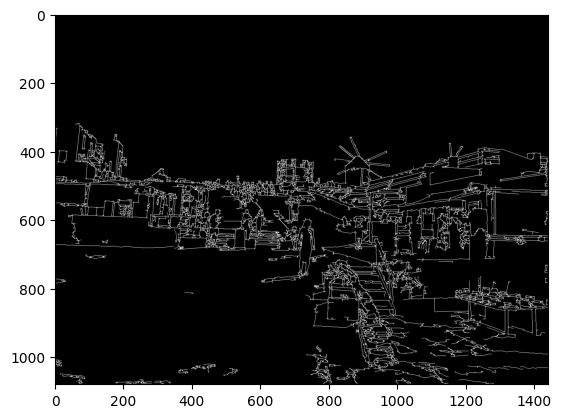

In [17]:
H_THRESHOLD = 0.5
L_THRESHOLD = 0.15


hysteresis_mask = np.zeros_like(max_suppressed)
hysteresis_mask[(max_suppressed < H_THRESHOLD) * (max_suppressed >= L_THRESHOLD)] = 0.5 # weak edges
hysteresis_mask[max_suppressed >= H_THRESHOLD] = 1 # strong edges


H, W = hysteresis_mask.shape

for i in range(1, H-1):
    for j in range(1, W-1):
        if hysteresis_mask[i, j] != 0.5:
            continue

        m = max( hysteresis_mask[i-1, j-1], hysteresis_mask[i-1, j], hysteresis_mask[i-1, j+1],
                 hysteresis_mask[i, j-1],                hysteresis_mask[i, j+1],
                 hysteresis_mask[i+1, j-1], hysteresis_mask[i+1, j], hysteresis_mask[i+1, j+1] )
        if m == 1: 
            hysteresis_mask[i, j] = 1

for i in range(H-2, 1, -1):
    for j in range(W-2, 1, -1):
        if hysteresis_mask[i, j] != 0.5:
            continue

        m = max( hysteresis_mask[i-1, j-1], hysteresis_mask[i-1, j], hysteresis_mask[i-1, j+1],
                 hysteresis_mask[i, j-1],                hysteresis_mask[i, j+1],
                 hysteresis_mask[i+1, j-1], hysteresis_mask[i+1, j], hysteresis_mask[i+1, j+1] )
        if m == 1: 
            hysteresis_mask[i, j] = 1

for i in range(1, H-1):
    for j in range(W-2, 1, -1):
        if hysteresis_mask[i, j] != 0.5:
            continue

        m = max( hysteresis_mask[i-1, j-1], hysteresis_mask[i-1, j], hysteresis_mask[i-1, j+1],
                 hysteresis_mask[i, j-1],                hysteresis_mask[i, j+1],
                 hysteresis_mask[i+1, j-1], hysteresis_mask[i+1, j], hysteresis_mask[i+1, j+1] )
        if m == 1: 
            hysteresis_mask[i, j] = 1

for i in range(H-2, 1, -1):
    for j in range(1, W-1):
        if hysteresis_mask[i, j] != 0.5:
            continue

        m = max( hysteresis_mask[i-1, j-1], hysteresis_mask[i-1, j], hysteresis_mask[i-1, j+1],
                 hysteresis_mask[i, j-1],                hysteresis_mask[i, j+1],
                 hysteresis_mask[i+1, j-1], hysteresis_mask[i+1, j], hysteresis_mask[i+1, j+1] )
        if m == 1: 
            hysteresis_mask[i, j] = 1
        

out = np.zeros_like(hysteresis_mask)
out[hysteresis_mask == 1] = 1
imshow(out)